In [1]:
import numpy as np

from tensorflow import keras

# データの拡張
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 画像の読込用
import matplotlib.image as mpimg

# 画像の表示用
import matplotlib.pyplot as plt

# 画像をPIL形式で読み込む。画像サイズの変更が可能
from tensorflow.keras.preprocessing import image as image_utils

# 画像の前処理
from tensorflow.keras.applications.imagenet_utils import preprocess_input

### ImageNetからのトレーニング済みモデルのダウンロード
[vgg16](https://jp.mathworks.com/help/deeplearning/ref/vgg16.html;jsessionid=60521754be7ed45b9f28ef156f36) 
VGG-16 は、深さが 16 層の畳み込みニューラル ネットワークです。100万枚を超えるイメージで学習させた事前学習済みのネットワークを、ImageNet データベースから読み込むことができます。  
この事前学習済みのネットワークは、イメージを 1000 個のオブジェクト カテゴリ (キーボード、マウス、鉛筆、多くの動物など) に分類できます。  
そのうち13個が畳み込み層で、3個が全結合層です。  

In [2]:
# 最初にImagenetからトレーニング済みモデルのダウンロード(約59MB)が必要
pre_model = keras.applications.VGG16(
    weights='imagenet',
    input_shape=(224, 224, 3),
    include_top=False) # ネットワークの出力層側にある3つの全結合層を含むかどうか

In [3]:
pre_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

### ベースモデルの凍結

In [4]:
# false で凍結
pre_model.trainable = False

### レイヤーの追加

In [5]:
### kerasのテンソルののインスタンスを作成
inputs = keras.Input(shape=(224, 224, 3))

x = pre_model(inputs, training=False) # training=False は推論モード

# 空間データのグローバルな平均プーリング演算
x = keras.layers.GlobalAveragePooling2D()(x)

# 通常の全結合ニューラルネットワークレイヤー
units = 2 # 出力空間の次元数、今回2項目分類を想定しているので出力層を 2 とする
outputs = keras.layers.Dense(units, activation = 'softmax')(x) # activation は 活性関数

# モデルをインスタンス化
revised_model = keras.Model(inputs, outputs)

In [6]:
revised_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 2)                 1026      
Total params: 14,715,714
Trainable params: 1,026
Non-trainable params: 14,714,688
_________________________________________________________________


### モデルのコンパイル

In [7]:
revised_model.compile(loss = keras.losses.BinaryCrossentropy(from_logits=True), 
              metrics = [keras.metrics.categorical_accuracy])

### データの拡張

In [8]:
datagen = ImageDataGenerator(
        featurewise_center=True, # データセット全体で，入力の平均を0にする
        samplewise_center=True,  # 各サンプルの平均を0にする
        rotation_range=10,  # 整数．画像をランダムに回転する回転範囲．
        zoom_range = 0.1, # 浮動小数点数または[lower，upper]．ランダムにズームする範囲．
                          # 浮動小数点数が与えられた場合，[lower, upper] = [1-zoom_range, 1+zoom_range]
        width_shift_range=0.1,  # r浮動小数点数（横幅に対する割合）．ランダムに水平シフトする範囲
        height_shift_range=0.1,  # 浮動小数点数（縦幅に対する割合）．ランダムに垂直シフトする範囲
        horizontal_flip=True,  # 水平方向に入力をランダムに反転
        vertical_flip=True # 垂直方向に入力をランダムに反転
)

### データセットの読み込み

In [9]:
# パスの設定
train_data_path = "data/train/"
test_data_path = "data/test/"

In [10]:
# 訓練データをフォルダから読み込む
# .flow_from_directory() ディレクトリへのパスを受け取り，拡張/正規化したデータのバッチを生成
train_it = datagen.flow_from_directory(train_data_path, # パス
                                       target_size=(244, 244), # リサイズする画像のサイズ 
                                       color_mode='rgb', # "grayscale"：白黒、"rbg"：カラー
                                       class_mode="categorical") 
                                       # "categorical"は2次元のone-hotにエンコード化されたラベル、"binary"は1次元の2値ラベル
                                       # "sparse"は1次元の整数ラベル，"input"は入力画像と同じ画像
# テストデータをフォルダから読み込む
test_it = datagen.flow_from_directory(test_data_path,
                                      target_size=(244, 244), 
                                      color_mode='rgb', 
                                      class_mode="categorical")

Found 36 images belonging to 2 classes.
Found 7 images belonging to 2 classes.


In [11]:
display(train_it.batch_size)
display(train_it.samples)

display(test_it.batch_size)
display(test_it.samples)

32

36

32

7

### モデルのトレーニング

In [12]:
revised_model.fit(train_it,
          validation_data=test_it,
          steps_per_epoch=train_it.samples/train_it.batch_size, # .samples データの数 バッチサイズは、ネットワークを介して伝播されるサンプルの数
          validation_steps=test_it.samples/test_it.batch_size,
          epochs=20)

C:\Users\kojis\anaconda3\envs\Pip ML\lib\site-packages\keras_preprocessing\image\image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/20
2/1 [=====================================================] - 8s 4s/step - loss: 0.7937 - categorical_accuracy: 0.3889 - val_loss: 0.7886 - val_categorical_accuracy: 0.4286
Epoch 2/20
2/1 [=====================================================] - 2s 1s/step - loss: 0.7161 - categorical_accuracy: 0.5833 - val_loss: 0.7879 - val_categorical_accuracy: 0.4286
Epoch 3/20
2/1 [=====================================================] - 2s 983ms/step - loss: 0.7292 - categorical_accuracy: 0.5278 - val_loss: 0.8536 - val_categorical_accuracy: 0.2857
Epoch 4/20
2/1 [=====================================================] - 7s 4s/step - loss: 0.7096 - categorical_accuracy: 0.5833 - val_loss: 0.7798 - val_categorical_accuracy: 0.2857
Epoch 5/20
2/1 [=====================================================] - 2s 988ms/step - loss: 0.6770 - categorical_accuracy: 0.6111 - val_loss: 0.7631 - val_categorical_accuracy: 0.4286
Epoch 6/20
2/1 [=====================================================] - 2

### モデルの評価

In [13]:
revised_model.evaluate(test_it, steps=test_it.samples/test_it.batch_size)

1/0 [=========================================================================================================================================] - 0s 2ms/step - loss: 0.6932 - categorical_accuracy: 0.5714


[0.6931740641593933, 0.5714285969734192]

### モデルの凍結を解除してファインチューニング

In [14]:
# 凍結の解除
pre_model.trainable = True

In [15]:
# コンパイル
revised_model.compile(optimizer=keras.optimizers.RMSprop(learning_rate = .00001),
              loss = keras.losses.BinaryCrossentropy(from_logits=True) , 
                      metrics =  [keras.metrics.categorical_accuracy])

In [16]:
# ファインチューニング
revised_model.fit(train_it,
          validation_data=test_it,
          steps_per_epoch=train_it.samples/train_it.batch_size,
          validation_steps=test_it.samples/test_it.batch_size,
          epochs=10)

Epoch 1/10
2/1 [=====================================================] - 6s 3s/step - loss: 0.5728 - categorical_accuracy: 0.8611 - val_loss: 0.5624 - val_categorical_accuracy: 0.8571
Epoch 2/10
2/1 [=====================================================] - 30s 15s/step - loss: 0.5696 - categorical_accuracy: 0.8611 - val_loss: 0.7101 - val_categorical_accuracy: 0.5714
Epoch 3/10
2/1 [=====================================================] - 29s 14s/step - loss: 0.5589 - categorical_accuracy: 0.8889 - val_loss: 0.5511 - val_categorical_accuracy: 0.8571
Epoch 4/10
2/1 [=====================================================] - 5s 3s/step - loss: 0.5360 - categorical_accuracy: 0.9444 - val_loss: 0.7403 - val_categorical_accuracy: 0.5714
Epoch 5/10
2/1 [=====================================================] - 28s 14s/step - loss: 0.5530 - categorical_accuracy: 0.8889 - val_loss: 0.5818 - val_categorical_accuracy: 0.8571
Epoch 6/10
2/1 [=====================================================] - 5

### モデルの評価

In [17]:
revised_model.evaluate(test_it, steps=test_it.samples/test_it.batch_size)

1/0 [=========================================================================================================================================] - 0s 4ms/step - loss: 0.5036 - categorical_accuracy: 1.0000


[0.503640353679657, 1.0]

### 分類結果の確認
[TensorFlow Core v2.3.0 doc](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/load_img)  
[TensorFlow, KerasでVGG16などの学習済みモデルを利用](https://note.nkmk.me/python-tensorflow-keras-applications-pretrained-models/)  

In [18]:
def show_image(image_path):
    image = mpimg.imread(image_path)
    plt.imshow(image)

def make_predictions(image_path):
    show_image(image_path) # 画像の表示
    image = image_utils.load_img(image_path, target_size=(224, 224)) # 画像の読込とサイズ変更
    image = image_utils.img_to_array(image) # 画像をnumpyのarrayデータに変更
    image = image.reshape(1,224,224,3) # 次元を変形 (画像の枚数、縦ピクセル数、横ピクセル数、RGB)
    image = preprocess_input(image) # Imagenetの重みデータに合わせた前処理を実行
    preds = revised_model.predict(image) # 予測値の算定
    return preds

1

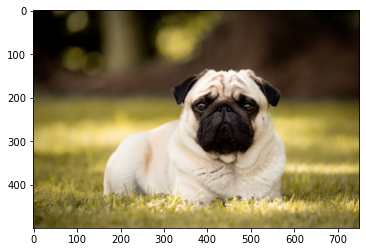

In [19]:
# 判定対象以外の写真の出力結果を表示
temp1 = make_predictions('data/test/non_duddy/not_duddy (19).jpg')
np.argmax(temp1)

0

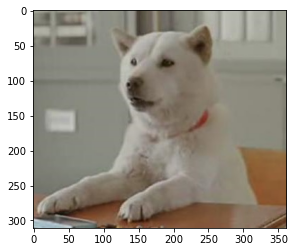

In [20]:
# 判定対象の写真の出力結果を表示
temp2 = make_predictions('data/test/duddy/duddy (1).jpg')
np.argmax(temp2)

0が判定対象、1が判定対象外と思われるので、判定結果を表示する関数に反映する

In [21]:
# 判定結果を表示する関数
def tasting_fruits(image_path):
    preds = make_predictions(image_path)
    if np.argmax(preds)>0:
        print("Who?")
    else:
        print("It's SHIRAI_Fammily's Duddy !")

Who?


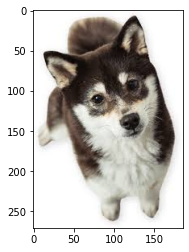

In [22]:
tasting_fruits('data/check/images.jpg')

It's SHIRAI_Fammily's Duddy !


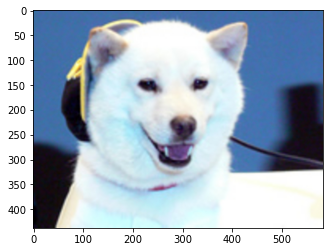

In [23]:
tasting_fruits('data/check/duddy.jpg')